In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('./Data/Collisions.csv')

In [4]:
code_to_pred = ["SEVERITYCODE"]

conditions = [
    "JUNCTIONTYPE",
    "WEATHER",
    "ROADCOND",
    "LIGHTCOND",
    "X",
    "Y",
    "ADDRTYPE"
]

indirect_cols = ["INCDTTM"] # Get Month and Period of Day


In [5]:
df = df[code_to_pred + conditions + indirect_cols]
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

In [6]:
# Extract year, month, day, hour and weekday

df['Month']   = df['INCDTTM'].dt.strftime('%b')
df['Hour']    = df['INCDTTM'].dt.hour
df['Weekday'] = df['INCDTTM'].dt.strftime('%a')

### Missing Values

SEVERITYCODE        1
JUNCTIONTYPE     8190
WEATHER         24199
ROADCOND        24120
LIGHTCOND       24286
X                   0
Y                   0
ADDRTYPE            0
INCDTTM             0
Month               0
Hour                0
Weekday             0
dtype: int64

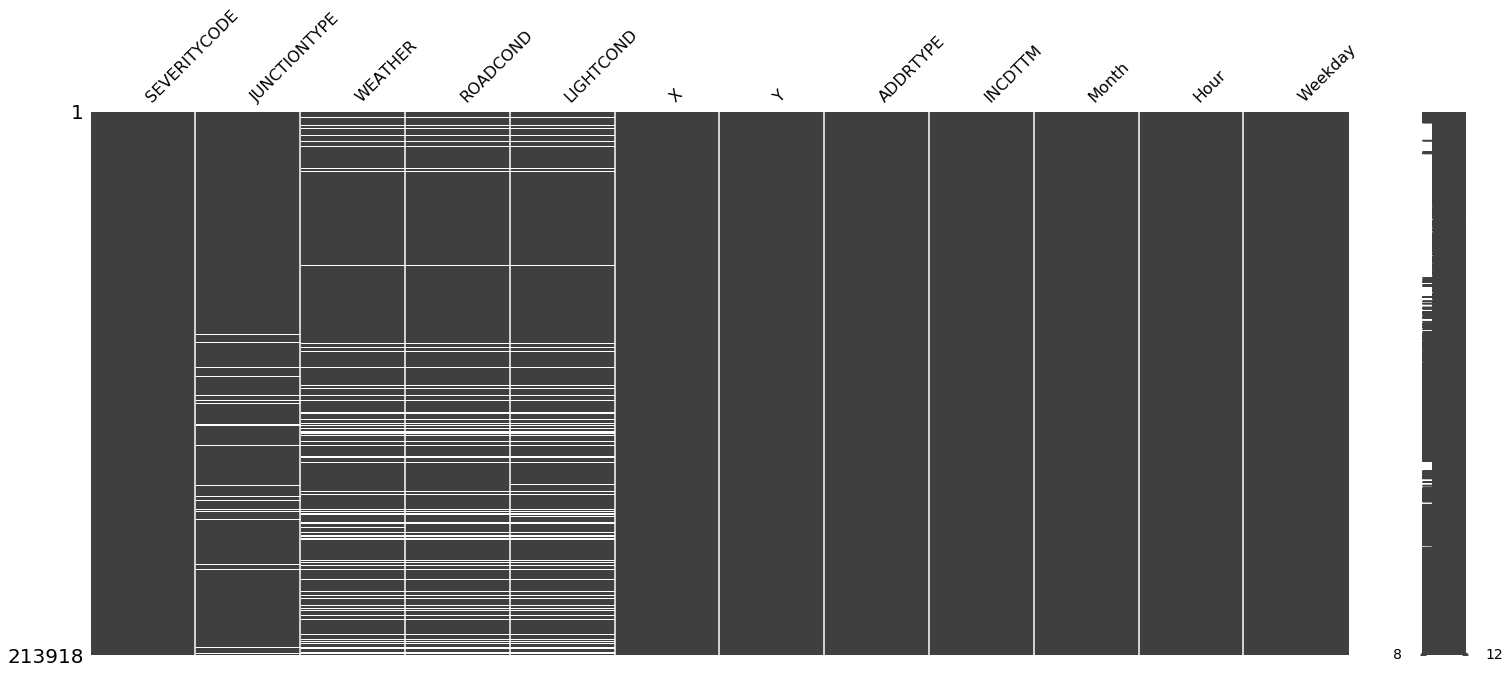

In [7]:
msno.matrix(df)
df.isna().sum()

In [8]:
df = df[pd.notna(df["SEVERITYCODE"])]
df.fillna("Unknown", inplace = True)

In [9]:
df["SEVERITYCODE"].unique()

array(['1', '0', '2', '2b', '3'], dtype=object)

## Data visualization

### Seattle Accident Map

In [10]:
# # !pip install folium
import folium
from folium.plugins import MarkerCluster
map_seattle = folium.Map(location=(df["Y"].mean(), df["X"].mean()), zoom_start=13)
marker_cluster_0 = MarkerCluster(name="Cluster_0").add_to(map_seattle)
marker_cluster_1 = MarkerCluster(name="Cluster_1").add_to(map_seattle)
marker_cluster_2 = MarkerCluster(name="Cluster_2").add_to(map_seattle)
marker_cluster_2b = MarkerCluster(name="Cluster_2b").add_to(map_seattle)
marker_cluster_3 = MarkerCluster(name="Cluster_3").add_to(map_seattle)

for lat, lon, sev in zip(list(df["Y"]), list(df["X"]), list(df["SEVERITYCODE"])):
    if sev == "0":
        folium.Circle([lat, lon], radius=5, color='yellow', fill=False).add_to(marker_cluster_0)
    if sev == "1":
        folium.Circle([lat, lon], radius=5, color='red', fill=False).add_to(marker_cluster_1)
    if sev == "2":
        folium.Circle([lat, lon], radius=5, color='orange', fill=False).add_to(marker_cluster_2)
    if sev == "2b":
        folium.Circle([lat, lon], radius=5, color='blue', fill=False).add_to(marker_cluster_2b)
    if sev == "3":
        folium.Circle([lat, lon], radius=5, color='green', fill=False).add_to(marker_cluster_3)

map_seattle.fit_bounds([[df["Y"].min(), df["X"].min()], [df["Y"].max(), df["X"].max()]])
# map_seattle.save(outfile= "test.html")

In [1]:
# map_seattle

![SealttleMaps.png](Data/Seattle_map.png)

### Accidents depending on Weather

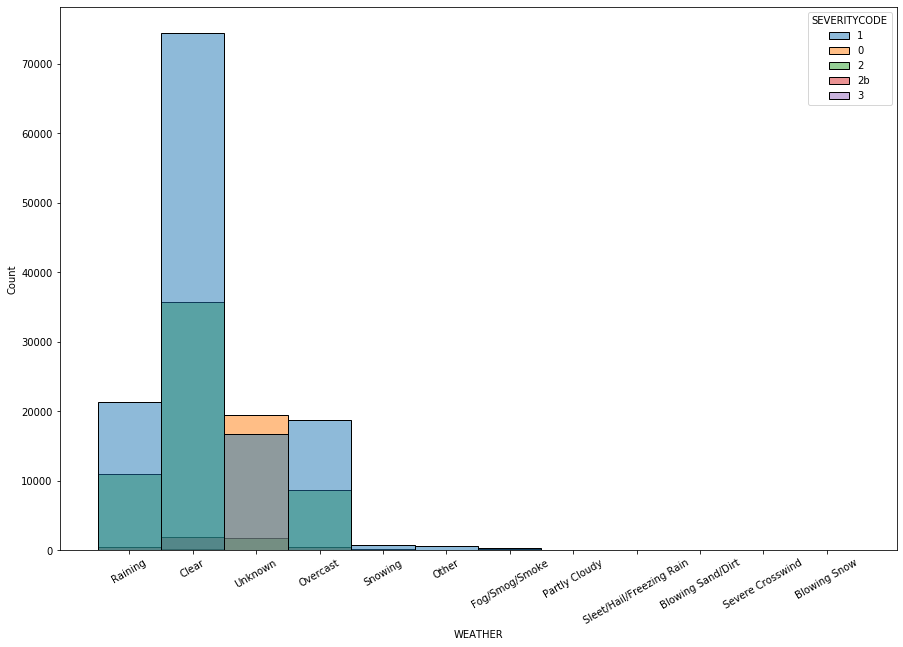

In [12]:
plt.figure(figsize=(15,10))
ax = sns.histplot(x="WEATHER", hue="SEVERITYCODE", data=df)
plt.setp(ax.get_xticklabels(), rotation=30);

### Accidents depending on weekday

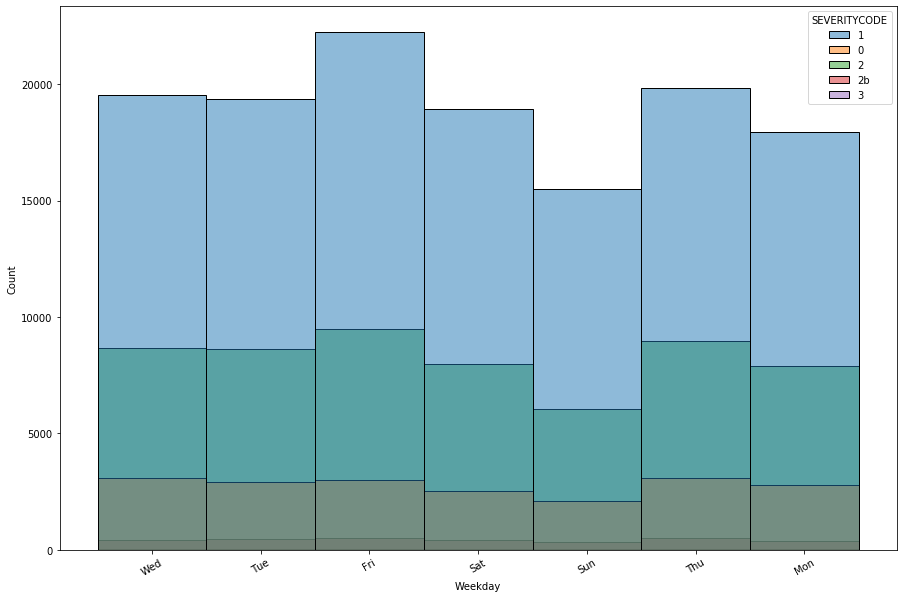

In [13]:
plt.figure(figsize=(15,10))
ax = sns.histplot(x="Weekday", hue="SEVERITYCODE", data=df)
plt.setp(ax.get_xticklabels(), rotation=30);

### Accidents depending on Light Condition

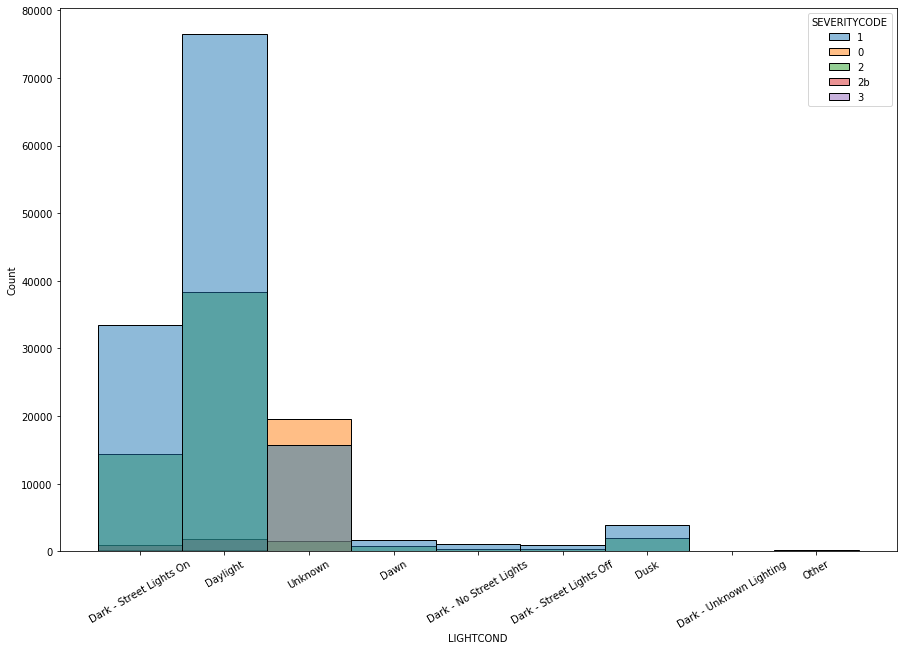

In [14]:
plt.figure(figsize=(15,10))
ax = sns.histplot(x="LIGHTCOND", hue="SEVERITYCODE", data=df)
plt.setp(ax.get_xticklabels(), rotation=30);

### Accidents depending on Road Condition

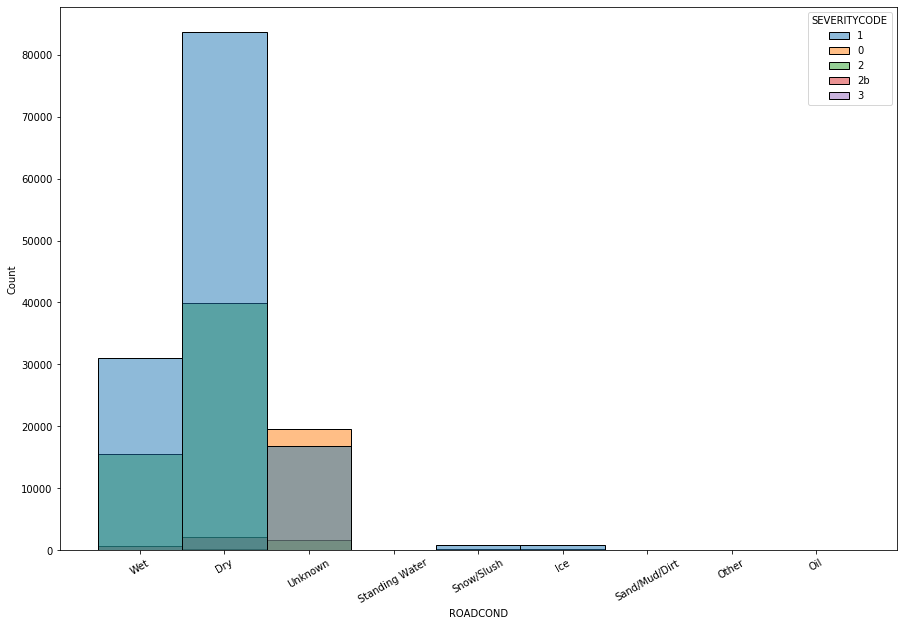

In [15]:
plt.figure(figsize=(15,10))
ax = sns.histplot(x="ROADCOND", hue="SEVERITYCODE", data=df)
plt.setp(ax.get_xticklabels(), rotation=30);

### Accidents depending on Junction Type

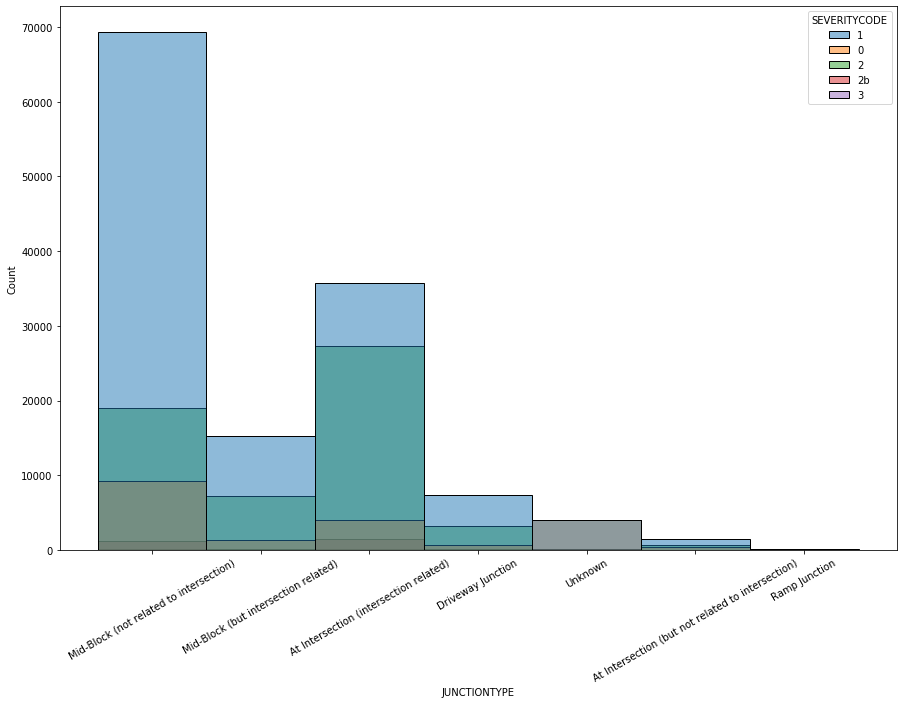

In [16]:
plt.figure(figsize=(15,10))
ax = sns.histplot(x="JUNCTIONTYPE", hue="SEVERITYCODE", data=df)
plt.setp(ax.get_xticklabels(), rotation=30);

### Accidents of different class

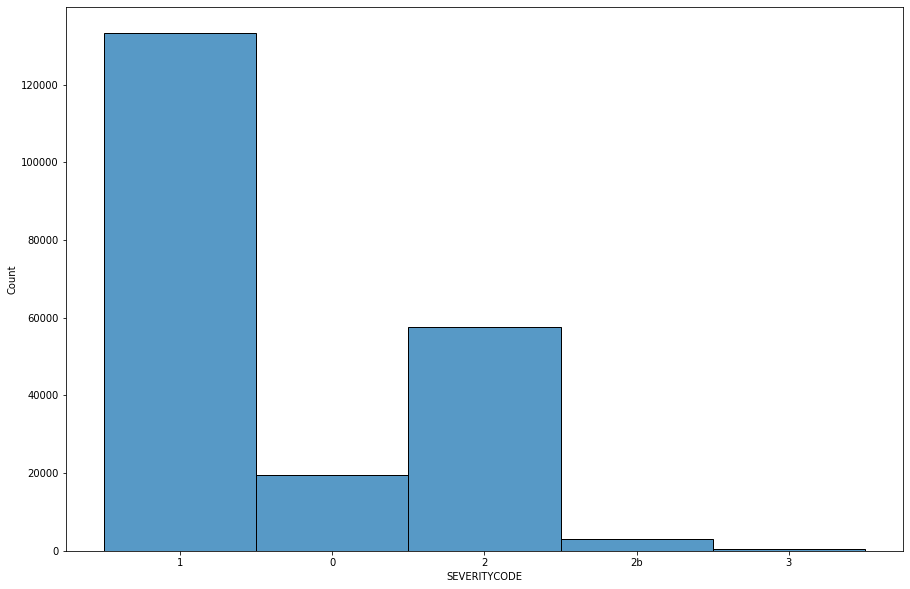

In [17]:
plt.figure(figsize=(15,10))
ax = sns.histplot(x="SEVERITYCODE", data=df)

# Data Preprocessing and Feature selection

### One Hot encoding

In [18]:
# Feature columns
feat_columns = ['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'ADDRTYPE', 'Month', 'Hour', 'Weekday']

# Prediction column
pred_columns = ['SEVERITYCODE']

clean_df = df[feat_columns + pred_columns]

# One Hot encoding
clean_df = pd.get_dummies(clean_df, drop_first=True, columns=feat_columns)

In [19]:
# Selecting Severity code 1 and 2 because other severeties are very less in number and these two are the priorities
clean_df = clean_df[(clean_df["SEVERITYCODE"] == "1") | (clean_df["SEVERITYCODE"] == "2")]

### Balancing dataset

In [20]:
sc1, sc_2 = clean_df['SEVERITYCODE'].value_counts()

# New dataframe based on lower total severity i.e. severity 2
df_sc2 = clean_df[clean_df['SEVERITYCODE'] == "2"]

#randomly select a dataframe within severity 1 based on number of severity 2 count
df_sc1 = clean_df[clean_df['SEVERITYCODE'] == "1"].sample(sc_2, random_state = 0)
final_df = pd.concat([df_sc1, df_sc2])

In [21]:
# Perfectly balanced dataset
final_df["SEVERITYCODE"].value_counts()

2    57675
1    57675
Name: SEVERITYCODE, dtype: int64

In [22]:
X = final_df.drop(columns=["SEVERITYCODE"])
y = final_df['SEVERITYCODE']

### Train-Test Data Generation

In [23]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, jaccard_similarity_score

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


def plot_conf_mat(y_true, y_pred, title, labels=['0', '1']):
    confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    conf_matrix = pd.DataFrame(
        data=confmat,
        columns=['Predicted:{}'.format(label) for label in labels],
        index=['Actual:{}'.format(label) for label in labels])
    sns.heatmap(
        conf_matrix, 
        annot=True,
        fmt='d',
        cmap="coolwarm").set_title(title, fontsize=16)
    plt.show()
    return

In [24]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (80745, 74) (80745,)
Test set: (34605, 74) (34605,)


# Classification

### KNN algorithm

In [25]:
## HyperParameter tuning (best_k = 5)

# best_k = -1
# best_acc = -1
# for k in range(1, 10):
#     knn_cl = knn(n_neighbors = k)
#     knn_cl.fit(X_train, y_train)
#     y_pred = knn_cl.predict(X_test)
#     acc_score = accuracy_score(y_test, y_pred)
#     print("k = {} ; Mean Accuracy = {}".format(k, acc_score))
#     if acc_score > best_acc:
#         best_k = k
#         best_acc = acc_score

# print("Best k =", best_k)
best_k = 5

In [26]:
# Final Model with best value of k

knn_cl = knn(n_neighbors = best_k)
knn_cl.fit(X_train, y_train)
y_pred_knn = knn_cl.predict(X_test)

knn_cl

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

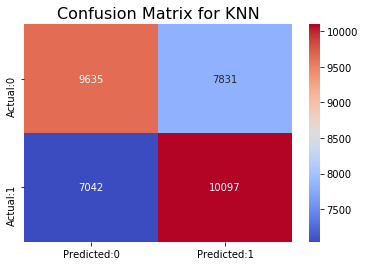

In [27]:
plot_conf_mat(y_test, y_pred_knn, "Confusion Matrix for KNN")

### Decision trees

In [28]:
## HyperParameter tuning (best_d = 6)

# best_d = -1
# best_f1 = -1

# for d in range(1, 20):
#     dt_cl = DecisionTreeClassifier(criterion = 'gini', max_depth = d)
#     dt_cl.fit(X_train, y_train)
#     y_pred = dt_cl.predict(X_test)
#     f1_sc = f1_score(y_test, y_pred, average = 'weighted')
#     print("k = {} ; F1 Score = {}".format(d, f1_sc))
#     if f1_sc > best_f1:
#         best_d = d
#         best_f1 = f1_sc
# print("Best d =", best_d)
best_d = 6

In [29]:
# Best Decision Tree model 

dt_cl = DecisionTreeClassifier(criterion = 'gini', max_depth = best_d)
dt_cl.fit(X_train, y_train)
y_pred_dt = dt_cl.predict(X_test)

dt_cl

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

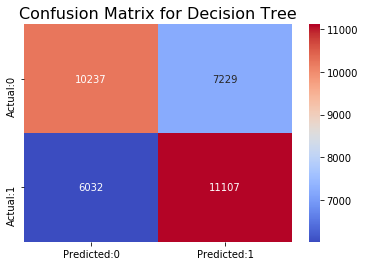

In [30]:
plot_conf_mat(y_test, y_pred_dt, "Confusion Matrix for Decision Tree")

### Random Forest

In [31]:
rdf_cl = RandomForestClassifier(n_estimators=300, random_state=0)
rdf_cl.fit(X_train, y_train)
y_pred_rdf = rdf_cl.predict(X_test)

rdf_cl

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

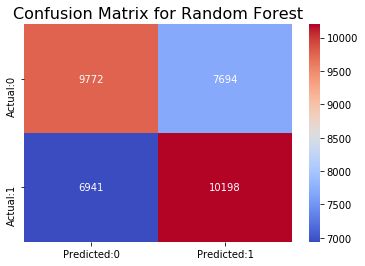

In [32]:
plot_conf_mat(y_test, y_pred_rdf, "Confusion Matrix for Random Forest")

# Model Evaluation

In [33]:
# KNN
jss1 = round(jaccard_similarity_score(y_test, y_pred_knn), 2)
f1 = round(f1_score(y_test, y_pred_knn, average = 'weighted'), 2)

# Decision Tree
jss2 = round(jaccard_similarity_score(y_test, y_pred_dt), 2)
f2 = round(f1_score(y_test, y_pred_dt, average = 'weighted'), 2)

# Random Forest
jss3 = round(jaccard_similarity_score(y_test, y_pred_rdf), 2)
f3 = round(f1_score(y_test, y_pred_rdf, average = 'weighted'), 2)

jss_list = [jss1, jss2, jss3]
f1_list = [f1, f2, f3]

/home/bibyutatsu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [34]:
columns = ['KNN', 'Decision Tree', 'Random Forest']
index = ['Jaccard', 'F1-score']
accuracy_df = pd.DataFrame([jss_list, f1_list], index = index, columns = columns).transpose()
accuracy_df.columns.name = 'Algorithm'
accuracy_df

Algorithm,Jaccard,F1-score
KNN,0.57,0.57
Decision Tree,0.62,0.62
Random Forest,0.58,0.58
